# ASL Code #
** Benjamin Tilden ** <br>
** Western Artificial Intelligence Club Project Team ** <br>
** Winter 2021 Project **

## Part 1 ##
** Import all libraries **
I would reccomend using anaconda https://www.anaconda.com/ otherwise you'll have to install all of the required packages with your package manager (usually pip).

In [21]:
import os
import numpy as np
# Open cv - used for real time computer vision 
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
# We will use these keras layer functions to improve our model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization


print("Loaded all libraries")

Loaded all libraries


## Part 2 ##
** Now we need to load our data set. Fortunately, we have training and testing data which are folders of files labeled accordingly to what letter they represent/should represent (testing data). **

In [22]:
# Specify our file path for where our data is
filePath = "../ASL/asl_alphabet_train/"
# Count how many 'categories/letters we have'
categories = os.listdir(filePath)
print(f"We have {len(categories)} categories of different ASL images in our training set.")


We have 29 categories of different ASL images in our training set.


Clearly, this is a supervised learning model because we are using labeled data, but before we pass each image as an input into the CNN, we need to have some sort of data of their labels. <br><br>
Yes, each image is titled as their letter and the image number, ex. 'A3.jpg', and they are in a folder, but our CNN does not understand english and cannot assume they are the same. <br><br>
Therefore, we need to index the labels, (make a = 0, b = 1, etc.), so the computer can understand. Additionally, the image will be read as pixes which are just matricies of numbers any way. <br><br>
If you are confused about this shoot me a message on discord!


** We are going to make a function that goes through all images and add them to an array, and also adds their corrosponding label to an array at the same index **

In [23]:
# Our input will be the location where our folders of training data is
def load_images_and_labels(categories, filePath):
    # Our return images and labels lists
    images = []
    labels = []
    # If you do not know what enumerate does, google it it's quite useful
    for index, category in enumerate(categories):
        numberOfImages = 0
        # Iterate through each folder ie: A, B, nothing, space, etc...
        for image in os.listdir(filePath+"/"+category):
            # Important!! we have 3000 images for each folder! that will take a lot of computing power and a lot of time
            # so if you want to limit your training data feel free to set a break point once your numberOfImages reaches a
            # certain number. Later, to improve our model we can see how changing the amount of training data affect the model error
            if numberOfImages == 1000: # We can start at 100
                break
            # We are using open cv to open each image then converts the color space of the image to RGB (blue green red -> red green blue)
            # Check out open CV documentation for more details
            img = cv2.imread(filePath+"/"+category+"/"+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Convert the image into an matrix of RGB values
            image_array = Image.fromarray(img, 'RGB')

            # Now we need to resize the image so they are all the same size (will create a 200 x 200 matrix of pixel values)
            resized_image = image_array.resize((64, 64))

            # Add the resized image to our training images list
            images.append(np.array(resized_image))

            # add the current index to our labels list, remeber our index will be a number which corrosponds to the label of the image
            labels.append(index)
            numberOfImages += 1
    
    return images, labels

# Call our function
images, labels = load_images_and_labels(categories, filePath)
print(f"Images loaded: {len(images)}")
print(f"Labels loaded: {len(labels)}")


Images loaded: 2900
Labels loaded: 2900


Fantastic! Now we have x number of images and labels loaded. But... they are of type 'list', our CNN will need to use numpy arrays, so we must convert our output

In [24]:
images = np.array(images)
labels = np.array(labels)

Our images will be an array that is x long, with each value being an image represented as a 200x200 matrix. <br><br>

Let's look at our data and see if we arrage the images and their corrosponding labels correctly!

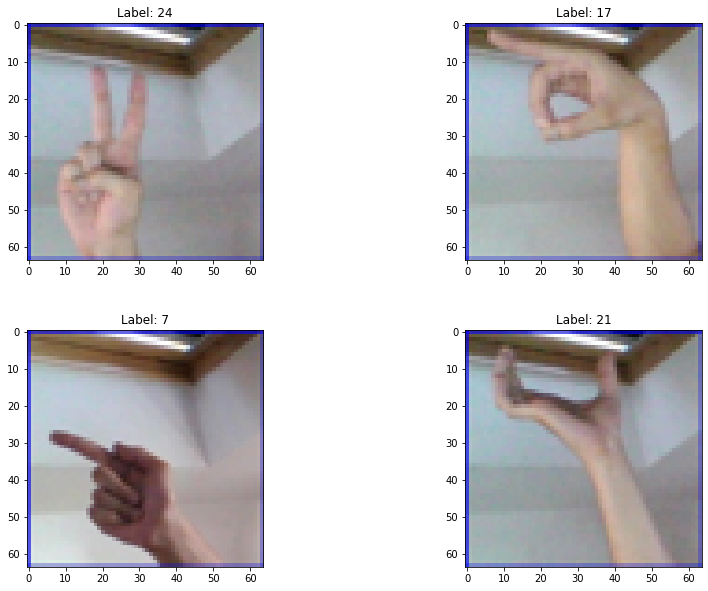

In [25]:
def display_random_images(images, labels):
    # Create our plotting grid
    plt.figure(1, figsize = (15, 10))
    n = 0
    for i in range(4):
        n += 1
        # Get a random index between 0 and the length of our images numpy array
        random_index = np.random.randint(0, images.shape[0], 1)

        # We are going to plot multiple images so this is going to specify a grid and how we plot them
        plt.subplot(2, 2, n)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
        plt.imshow(images[random_index[0]])
        plt.title("Label: {}".format(labels[random_index[0]]))
    
    plt.show()

display_random_images(images, labels)

## Part 3 ##
** Terrific! We now have some beautiful data: ** <br><br>
1) A numpy array of x images, each image represented by a 200x200 matrix <br>
2) A numpy array of x size, where each value corrosponding to the image at the same index <br><br>

Now we are going to normalize the data, which means we will ensure all of the data in the arrays are of the same type and size.

In [26]:
# Set the images array to all floats
# Set the labels array to all ints
# Divide the images array by 255, this is because the values of each image are of RGB which is a scale from 0 to 255, so we are effictively making these a decimal from 0 to 1 now
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255


Let's check now our random images again.

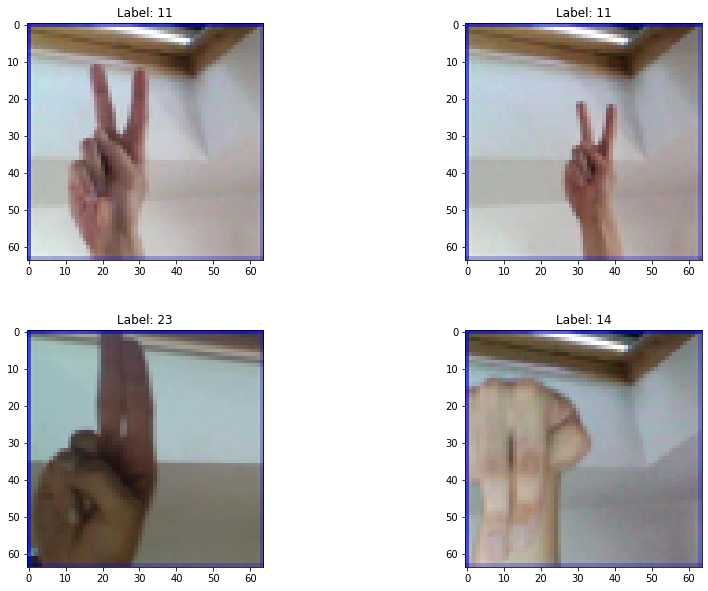

In [27]:
display_random_images(images, labels)

Now is the fun step, we get to split our data into the testing and training data. 

In [28]:
# The test size is current set to 0.2, which means 20% of the data will split and used for testing our model
# The test size is an aspect that can be changed to improve your mode, I encourage you to look into the formula
# which calculates the ideal test size for a model
# We also set our random state to the random seed. Google for more information, basically randomizes our data.
xTrain, xTest, ytrain, ytest = train_test_split(images, labels, test_size = 0.1)

print(f"xTrain shape = {xTrain.shape}")
print(f"xTest shape = {xTest.shape}")
print(f"ytrain shape = {ytrain.shape}")
print(f"xtest shape = {ytest.shape}")

xTrain shape = (2610, 64, 64, 3)
xTest shape = (290, 64, 64, 3)
ytrain shape = (2610,)
xtest shape = (290,)


Great! Now we see that of our x total images, we will be using 0.8x images to train our model, and 0.2x images available to test our model!

## Part 4 ##
** Next we will build our CNN model and train it **

In [29]:
model = Sequential()

# Add our first convolutional layer to the model

# Conv2D = Simple CNN constructor
# kernel_size = 3 (will be read as 3x1) This is because each pized is represented by a 3 tuple (x, y, z) in the form RGB where x, y, z are numbers between 0 and 1 (we changed it from 0 to 255)
# activation = simple string name of the activation function that will be applied after the model ReLU
# input_shape = our training data without the indexed numbers (first column)
model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu", input_shape = xTrain.shape[1:]))

# Add a max pooling layer (this is traditionally done after an activation function has been applied to a layer)
# Check out this link for an indepth description https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

model.add(MaxPooling2D(pool_size = 3))

# Add another layer
model.add(Conv2D(filters = 256, kernel_size = 3, activation = "relu", input_shape = xTrain.shape[1:]))
model.add(MaxPooling2D(pool_size = 3))

# Add another Conv2d layer
# Notice how we are increasing the filters 
model.add(Conv2D(filters =512, kernel_size = 3, activation = "relu", input_shape = xTrain.shape[1:]))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size = 3))

# Add a batch normalization layer
# The batch normalization will be applied to our layer output (so far) and will normalize the data mean close to 0 and the standard deviation to 1
model.add(BatchNormalization())

# Flatten the model
# Puts all data into a (1 x N) array
model.add(Flatten())


Great progress so far! Now we are going to add some dense layers to our model. Dense layers in a CNN mean that each neuron is connected to every neuron in the following layers.


In [30]:
# Dropout layers are randomly selected neurons that will be ignored during training to prevent overfitting
model.add(Dropout(0.5))
# The 1024 will be the dimensionality of our output space, HINT: this could be changed to improve our model once complete
model.add(Dense(1024, activation = "sigmoid"))

Fantastic! Almost done. Now all we need to do is create the output later of out model!

In [31]:
# 29 is our output because we have 29 different categories, remember?!
# Softmax is an activation function applied after the layer is created 
# Softmax converts a real vector to a vector of categorical probabilities where the elements are in range 0 to 1 and sum to 1
model.add(Dense(29, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 256)       295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 512)         1180160   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 512)        

Now, let's compile our CNN!

In [32]:
# Optimizer = Adam - this optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# Loss = SparseCategoricalCrossentropy - Computes the crossentropy loss between the labels and predictions
# Metrics = Accuracy - Calculates how often predictions equal labels.
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Finally! Now let's train our model with our xTrain and yTrain data!

## Part 5 ##
** Model Training **

In [33]:
# Epochs = 100 - The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. HINT: Maybe we should increase this later.
# batch_size = 100 (The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
# Think of a batch as a for-loop iterating over one or more samples and making predictions) - we set it to 100 because we have 100 images for each label, remember?

"""
Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.

This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.

This also means that one epoch will involve 40 batches or 40 updates to the model.

With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process
"""

#WARNING: THIS STEP WILL TAKE A VERY LONG TIME, consider adjusting parameters to increase speed but I reccomend you wait to see how the network is trained over 100 iterations 
modelData = model.fit(xTrain, ytrain, epochs=10, batch_size=128, shuffle=True, validation_split=0.1, verbose=1)
model.summary()

Epoch 1/10
19/19 [==============================] - 10s 515ms/step - loss: 3.0196 - accuracy: 0.1693 - val_loss: 5.0085 - val_accuracy: 0.0230
Epoch 2/10
19/19 [==============================] - 10s 513ms/step - loss: 1.6268 - accuracy: 0.5657 - val_loss: 5.4526 - val_accuracy: 0.0613
Epoch 3/10
19/19 [==============================] - 10s 509ms/step - loss: 0.9361 - accuracy: 0.7999 - val_loss: 4.9947 - val_accuracy: 0.0881
Epoch 4/10
19/19 [==============================] - 10s 516ms/step - loss: 0.5219 - accuracy: 0.9097 - val_loss: 4.9231 - val_accuracy: 0.0575
Epoch 5/10
19/19 [==============================] - 10s 523ms/step - loss: 0.3110 - accuracy: 0.9457 - val_loss: 3.6731 - val_accuracy: 0.1341
Epoch 6/10
19/19 [==============================] - 10s 519ms/step - loss: 0.2017 - accuracy: 0.9694 - val_loss: 3.2510 - val_accuracy: 0.2031
Epoch 7/10
19/19 [==============================] - 10s 512ms/step - loss: 0.1223 - accuracy: 0.9844 - val_loss: 2.5329 - val_accuracy: 0.2797

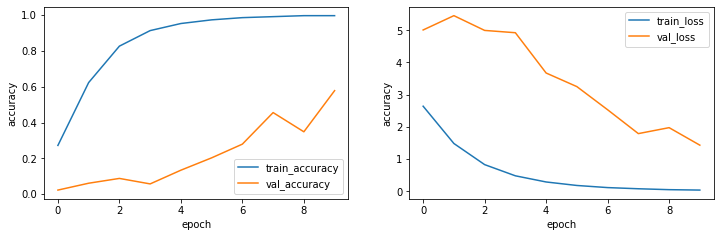

In [34]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(modelData.history['accuracy'], label = 'train_accuracy')
plt.plot(modelData.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(modelData.history['loss'], label = 'train_loss')
plt.plot(modelData.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Wow! Looks like our accuracy is pretty good now for our training model! <br>
Let's test it on our test data now to see!

In [35]:
loss, accuracy = model.evaluate(xTest, ytest)

10/10 [==============================] - 0s 34ms/step - loss: 1.3665 - accuracy: 0.5828


Hmm, I wonder why the accuraacy is so low on our test data when our model is 99% accurate? What do you think is the reason for this?

## Part 6 ##
** Predicting Values **

In [36]:
pred = model.predict(xTest)
pred.shape

(290, 29)

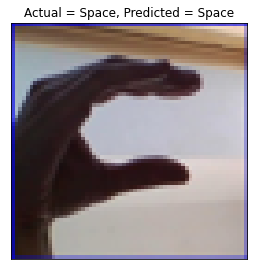

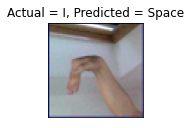

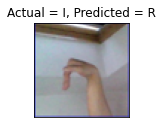

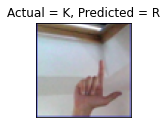

In [37]:
plt.figure(1, figsize=(15, 10))
n = 0

num_to_alpha = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

for i in range(4):
    n += 1
    r = np.random.randint(0, xTest.shape[0], 1)

    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.imshow(xTest[r[0]])

    arg1 = ytest[r[0]]
    arg2 = int(round(ytest[r[0]] * pred[r[0]][ytest[r[0]]]))

    plt.title(f'Actual = {num_to_alpha[arg1]}, Predicted = {num_to_alpha[arg2]}')
    plt.xticks([])
    plt.yticks([])

    plt.show()